### import

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import (
    gamma, expon, chi2, weibull_min, lognorm,
    johnsonsu, johnsonsb, fisk, triang, pearson3,
    kstest
)
from tqdm import tqdm
import time

In [4]:
# 시각화 함수
def visualize(df, min_date='2020-01-01', max_date=None):

    # Step 1: Identify the relevant columns
    date_columns = ['LON_DE', 'RESVE_DE', 'RTURN_DE', 'REGIST_DE']
    present_columns = [col for col in date_columns if col in df.columns]

    if not present_columns:
        print("No relevant columns found in the dataset.")
        return

    for col in present_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    min_date = pd.to_datetime(min_date)
    max_date = pd.to_datetime(max_date) if max_date else None

    for col in present_columns:
        if df[col].notna().sum() > 0:
            filtered_data = df[col].dropna()
            filtered_data = filtered_data[filtered_data >= min_date]
            if max_date:
                filtered_data = filtered_data[filtered_data <= max_date]

            weekly_data = filtered_data.dt.to_period('W').value_counts().sort_index()

            plt.figure(figsize=(10, 6))
            weekly_data.index = weekly_data.index.to_timestamp()
            plt.plot(weekly_data.index, weekly_data.values, marker='o', linestyle='-')
            plt.title(f'Weekly Trend for {col}')
            plt.xlabel('Week')
            plt.ylabel('Count')
            plt.grid(True)
            plt.show()
        else:
            print(f"Column {col} contains no valid date data.")

# 특정 이름의 책에 대한 대출, 반납률 산출 함수
def find_book(name, book_data, loan_data):
    no_list = list(book_data[book_data['TITLE_NM'] == name]['CTRL_NO'])
    loan_list = []

    for no in tqdm(no_list):
        temp = loan_data[loan_data['BOOK_KEY_NO'] == no].copy()
        loan_list.append(temp)

    result_df = pd.concat(loan_list, ignore_index=True)
    result_df['LON_DE'] = result_df['LON_DE'].str.split(' ').str[0]
    result_df['RTURN_DE'] = result_df['RTURN_DE'].str.split(' ').str[0]
#    result_df['RESVE_DE'] = result_df['RESVE_DE'].str.split(' ').str[0]
#    result_df['RESVE_END_DE'] = result_df['RESVE_END_DE'].str.split(' ').str[0]

    result_df['LON_DE'] = pd.to_datetime(result_df['LON_DE'], format='%Y-%m-%d')
    result_df['RTURN_DE'] = pd.to_datetime(result_df['RTURN_DE'], format='%Y-%m-%d')
#    result_df['RESVE_DE'] = pd.to_datetime(result_df['RESVE_DE'], format='%Y-%m-%d')
#    result_df['RESVE_END_DE'] = pd.to_datetime(result_df['RESVE_END_DE'], format='%Y-%m-%d')

    result_df = result_df.drop_duplicates(subset='SEQ_NO', keep='first')
    result_df = result_df.sort_values(by='LON_DE')
    result_df['ARRIVAL_DIFF'] = result_df['LON_DE'].diff().dt.days
    result_df['SERVICE_DIFF'] = (result_df['RTURN_DE'] - result_df['LON_DE']).dt.days
    result_df['MISSING'] = result_df['RTURN_DE'].isna().astype(int)

    # 확인차 평균값 산출
    result_df['ARRIVAL_TIME'] = result_df['ARRIVAL_DIFF'].mean()
    result_df['SERVICE_TIME'] = result_df['SERVICE_DIFF'].mean()
    result_df['MISSING_RATE'] = result_df['MISSING'].mean()

    required_columns = [
        "SEQ_NO", "BOOK_KEY_NO", "LON_DE",
        "RTURN_DE", "RESVE_DE", "RESVE_END_DE",
        "ARRIVAL_DIFF", "SERVICE_DIFF", "MISSING",
        "ARRIVAL_TIME", "SERVICE_TIME", "MISSING_RATE"
    ]

    result_df = result_df[required_columns]

    return result_df

# 분포 확인 함수
def gen_dist(data):
    plt.figure(figsize=(14, 6))

    # ARRIVAL_DIFF 히스토그램
    plt.subplot(1, 2, 1)
    plt.hist(data['ARRIVAL_DIFF'].dropna(), bins=20, edgecolor='black')
    plt.title('Arrival Time Differences')
    plt.xlabel('Days')
    plt.ylabel('Frequency')

    # SERVICE_DIFF 히스토그램
    plt.subplot(1, 2, 2)
    plt.hist(data['SERVICE_DIFF'].dropna(), bins=20, edgecolor='black')
    plt.title('Service Times')
    plt.xlabel('Days')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


### 데이터

In [5]:
os.chdir('/content/drive/MyDrive/File_Korea.Univ/2024 2학기/시뮬레이션 및 실습(백준걸 교수님)/Team Project')
bd_1 = pd.read_csv('book_data.csv')
bd_2 = pd.read_csv('book_data23_24.csv')
bd = pd.concat([bd_1, bd_2], ignore_index=True)
df = pd.read_csv('loan.csv')

<ipython-input-5-95de103f2057>:5: DtypeWarning: Columns (1,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan.csv')


In [6]:
df

,SEQ_NO,BOOK_KEY_NO,MBER_SEQ_NO_VALUE,LON_DE,RTURN_DE,LBRRY_CD,LON_STLE_NM,RTURN_STLE_NM,RTURN_PREARNGE_DE,RESVE_DE,RESVE_END_DE,LON_STATE_NM,LON_PLACE_NM,RTURN_PLACE_NM,MANAGE_LBRRY_CD,LON_LBRRY_CD,RTURN_LBRRY_CD,MASTR_LBRRY_CD
0,96745157,96238312,dd1bc79e0940239f922e6ce62e537373be1ec23f5fe96e...,2024-05-23 12:00:00,2024-05-31 12:00:00,4529,0,0.0,2024-06-07 12:00:00.0,NaN,NaN,1,KOLASIII,KOLASIII,MD,MD,MD,4500
1,96745159,96238256,dd1bc79e0940239f922e6ce62e537373be1ec23f5fe96e...,2024-05-23 12:00:00,2024-05-31 12:00:00,4529,0,0.0,2024-06-07 12:00:00.0,NaN,NaN,1,KOLASIII,KOLASIII,MD,MD,MD,4500
2,96745161,96238241,dd1bc79e0940239f922e6ce62e537373be1ec23f5fe96e...,2024-05-23 12:00:00,2024-05-31 12:00:00,4529,0,0.0,2024-06-07 12:00:00.0,NaN,NaN,1,KOLASIII,KOLASIII,MD,MD,MD,4500
3,96745178,96238244,dd1bc79e0940239f922e6ce62e537373be1ec23f5fe96e...,2024-05-23 12:00:00,2024-05-31 12:00:00,4529,0,0.0,2024-06-07 12:00:00.0,NaN,NaN,1,KOLASIII,KOLASIII,MD,MD,MD,4500
4,96745259,69273807,2a993b30e452b038d24aa627e8487fabe3c1fa97622a07...,2024-05-23 12:00:00,2024-06-16 12:00:00,4529,3,0.0,2024-06-14 12:00:00.0,NaN,NaN,1,SMARTID,KOLASIII,MD,MD,MD,4500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53247507,74210347,73172477,e1d1b892e36029bb5e00e1fe514d75c2bf9300dbf13a15...,2024-09-29,NaN,33800,3,NaN,2024-10-13,NaN,NaN,2,KOLASIII,NaN,MA,NaN,NaN,33800
53247508,74210348,73608302,e1d1b892e36029bb5e00e1fe514d75c2bf9300dbf13a15...,2024-09-29,NaN,33800,3,NaN,2024-10-13,NaN,NaN,2,KOLASIII,NaN,MA,NaN,NaN,33800
53247509,74210349,72361764,e1d1b892e36029bb5e00e1fe514d75c2bf9300dbf13a15...,2024-09-29,NaN,33800,3,NaN,2024-10-13,NaN,NaN,2,KOLASIII,NaN,MA,NaN,NaN,33800
53247510,74210350,73057919,e1d1b892e36029bb5e00e1fe514d75c2bf9300dbf13a15...,2024-09-29,NaN,33800,3,NaN,2024-10-13,NaN,NaN,2,KOLASIII,NaN,MA,NaN,NaN,33800


In [7]:
book1 = find_book('1984', bd, df)
gen_dist(book1)

 58%|█████▊    | 111/190 [04:57<03:32,  2.68s/it]


KeyboardInterrupt: 

In [ ]:
book2 = find_book('코스모스', bd, df)
gen_dist(book2)

In [ ]:
book3 = find_book('총, 균, 쇠', bd, df)
gen_dist(book3)

In [ ]:
book1.to_csv('book_1984.csv', index=False)
book2.to_csv('book_코스모스.csv', index=False)
book3.to_csv('book_총, 균, 쇠.csv', index=False)

In [ ]:
book1 = book1.drop_duplicates(subset='SEQ_NO', keep='first')
book2 = book2.drop_duplicates(subset='SEQ_NO', keep='first')
book3 = book3.drop_duplicates(subset='SEQ_NO', keep='first')
gen_dist(book1)
gen_dist(book2)
gen_dist(book3)

### 분포피팅

In [8]:
book1 = pd.read_csv('book_1984.csv')
book2 = pd.read_csv('book_코스모스.csv')
book3 = pd.read_csv('book_총, 균, 쇠.csv')
book1 = book1.drop_duplicates(subset='SEQ_NO', keep='first')
book2 = book2.drop_duplicates(subset='SEQ_NO', keep='first')
book3 = book3.drop_duplicates(subset='SEQ_NO', keep='first')

In [9]:
# Homogeneity Test
def test_homogeneity(book1, book2, book3, column):

    data1 = book1[column].dropna()
    data2 = book2[column].dropna()
    data3 = book3[column].dropna()
    statistic, p_value = stats.kruskal(data1, data2, data3)

    return statistic, p_value

# ARRIVAL_DIFF
arr_stat, arr_p = test_homogeneity(book1, book2, book3, 'ARRIVAL_DIFF')
print("Kruskal-Wallis test for ARRIVAL_DIFF:")
print("H-statistic:", arr_stat, "P-value:", arr_p)

if arr_p < 0.05:
    print("유의수준 5%에서 ARRIVAL_DIFF 분포가 동일하다고 보기 어렵습니다.")
else:
    print("ARRIVAL_DIFF 분포의 유의미한 차이가 존재하지 않는다.")

# SERVICE_DIFF
svc_stat, svc_p = test_homogeneity(book1, book2, book3, 'SERVICE_DIFF')
print("\nKruskal-Wallis test for SERVICE_DIFF:")
print("H-statistic:", svc_stat, "P-value:", svc_p)

if svc_p < 0.05:
    print("유의수준 5%에서 SERVICE_DIFF 분포가 동일하다고 보기 어렵습니다.")
else:
    print("SERVICE_DIFF 분포의 유의미한 차이가 존재하지 않는다.")

Kruskal-Wallis test for ARRIVAL_DIFF:
H-statistic: 2.4274541609621925 P-value: 0.29708794274791667
ARRIVAL_DIFF 분포의 유의미한 차이가 존재하지 않는다.

Kruskal-Wallis test for SERVICE_DIFF:
H-statistic: 2.03518224107413 P-value: 0.3614646169716499
SERVICE_DIFF 분포의 유의미한 차이가 존재하지 않는다.


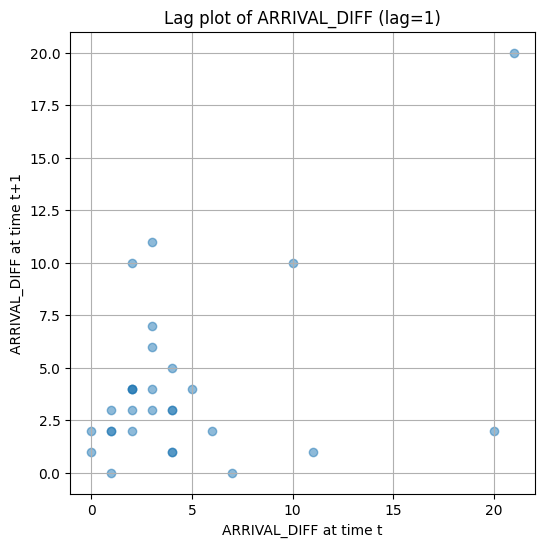

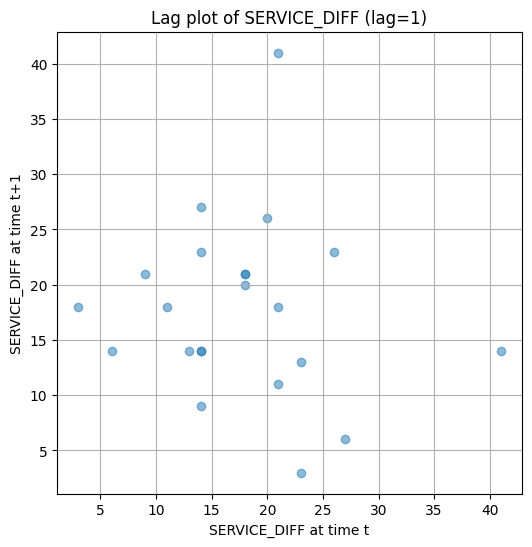

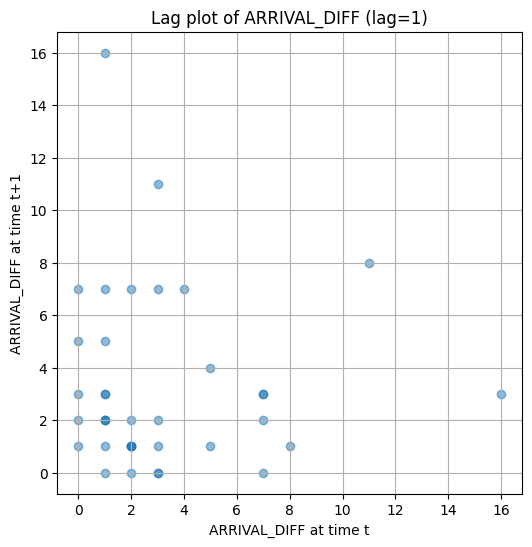

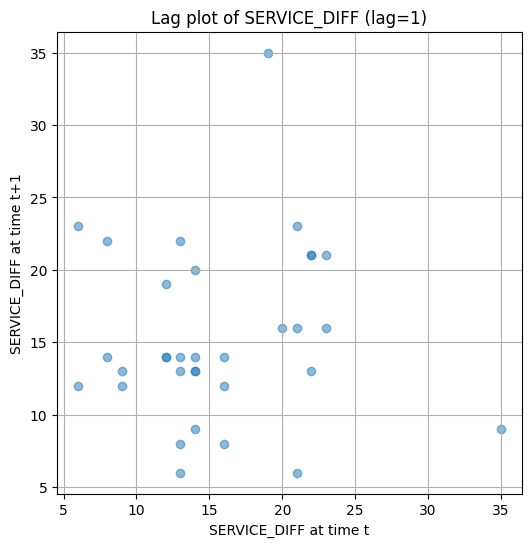

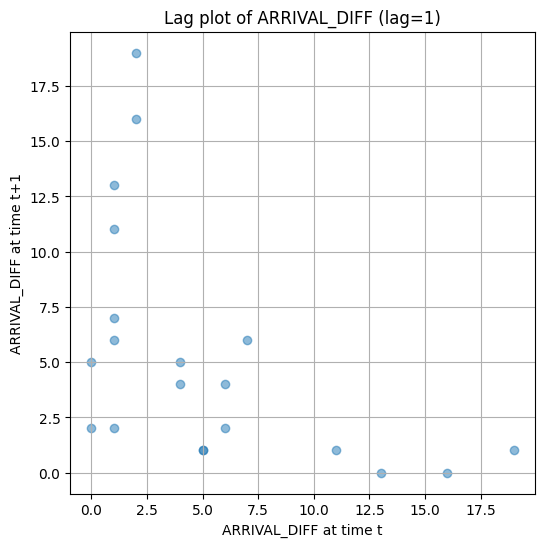

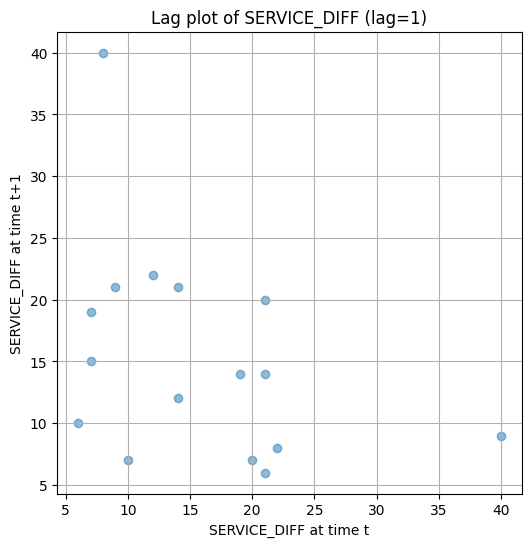

In [10]:
# Independence Test
import matplotlib.pyplot as plt
import pandas as pd

def lag_plot(data, column, lag=1):

    if column not in data.columns:
        print(f"{column} not found in data")
        return

    series = data[column].dropna().reset_index(drop=True)

    # lag만큼 시프트
    lagged = series.shift(-lag)

    # 유효한 pair만 추출
    valid = pd.concat([series, lagged], axis=1).dropna()
    x = valid.iloc[:, 0]
    y = valid.iloc[:, 1]

    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, alpha=0.5)
    plt.title(f'Lag plot of {column} (lag={lag})')
    plt.xlabel(f'{column} at time t')
    plt.ylabel(f'{column} at time t+{lag}')
    plt.grid(True)
    plt.show()

# 예시 사용 (book1에 대해)
lag_plot(book1, 'ARRIVAL_DIFF', lag=1)
lag_plot(book1, 'SERVICE_DIFF', lag=1)

# book2, book3에 대해서도 동일하게 가능
lag_plot(book2, 'ARRIVAL_DIFF', lag=1)
lag_plot(book2, 'SERVICE_DIFF', lag=1)

lag_plot(book3, 'ARRIVAL_DIFF', lag=1)
lag_plot(book3, 'SERVICE_DIFF', lag=1)

In [11]:
# Data Merging - 병합할 필요 없어서 보류

excluded_cols = ['ARRIVAL_TIME', 'SERVICE_TIME', 'MISSING_RATE']

book_df = pd.concat([
    book1.drop(columns=excluded_cols, errors='ignore'),
    book2.drop(columns=excluded_cols, errors='ignore'),
    book3.drop(columns=excluded_cols, errors='ignore')
], ignore_index=True)

book_df


,SEQ_NO,BOOK_KEY_NO,LON_DE,RTURN_DE,LBRRY_CD,RESVE_DE,RESVE_END_DE,ARRIVAL_DIFF,SERVICE_DIFF,MISSING
0,435821957,98388823,2024-05-11,2024-06-01,104,NaN,NaN,NaN,21.0,0
1,436166521,98388823,2024-06-01,2024-07-12,104,NaN,NaN,21.0,41.0,0
2,436799078,112410903,2024-06-21,NaN,108,NaN,NaN,20.0,NaN,1
3,74180676,70090677,2024-06-23,2024-07-07,32700,NaN,NaN,2.0,14.0,0
4,436906001,104001840,2024-06-27,2024-07-24,107,NaN,NaN,4.0,27.0,0
...,...,...,...,...,...,...,...,...,...,...
88,100203259672,106507846,2024-08-29,2024-09-19,26501,NaN,NaN,5.0,21.0,0
89,438444163,407524999,2024-08-30,2024-09-05,108,NaN,NaN,1.0,6.0,0
90,438904281,408236470,2024-09-12,2024-09-22,115,NaN,NaN,13.0,10.0,0
91,438890194,407524999,2024-09-12,2024-09-19,114,NaN,NaN,0.0,7.0,0


In [12]:
# Fitting Distribution

def fit_and_test_distributions(data):
    """
    데이터를 다양한 분포에 피팅한 후 Kolmogorov-Smirnov 검정을 수행하여
    가장 적합한 분포를 선택.
    """
    # NaN 제거 및 array 변환
    data = np.asarray(data.dropna() if isinstance(data, pd.Series) else data)
    data = data[~np.isnan(data)]

    distributions = {
        'gamma': gamma,
        'exponential': expon,
        'chi2': chi2,
        'weibull_min': weibull_min,
        'lognorm': lognorm,
        'johnsonsu': johnsonsu,
        'johnsonsb': johnsonsb,
        'fisk': fisk,          # Fisk = log-logistic distribution
        'triang': triang,
        'pearson3': pearson3
    }

    results = []

    for dist_name, dist in distributions.items():
        try:
            # 분포 피팅 및 파라미터 추정
            params = dist.fit(data)
            # Kolmogorov–Smirnov 검정
            D, p_value = kstest(data, dist.cdf, args=params)
            results.append((dist_name, params, D, p_value))
        except Exception as e:
            print(f"Could not fit {dist_name}: {e}")

    # 가장 적합한 분포 선택 (p-value 기준)
    best_fit = max(results, key=lambda x: x[3]) if results else None

    return results, best_fit

def visualize_fitted_distribution(data, dist_name, params, bins=30, title='Fitted Distribution'):

    # 데이터 정리
    data = np.asarray(data.dropna() if isinstance(data, pd.Series) else data)
    data = data[~np.isnan(data)]

    # 히스토그램
    counts, bin_edges, _ = plt.hist(data, bins=bins, density=True, alpha=0.6, color='g', edgecolor='black')
    x = np.linspace(bin_edges[0], bin_edges[-1], 1000)  # 분포를 그릴 x 값 범위

    # 분포 가져오기
    distributions = {
        'gamma': gamma,
        'exponential': expon,
        'chi2': chi2,
        'weibull_min': weibull_min,
        'lognorm': lognorm,
        'johnsonsu': johnsonsu,
        'johnsonsb': johnsonsb,
        'fisk': fisk,
        'triang': triang,
        'pearson3': pearson3
    }

    if dist_name not in distributions:
        print(f"Distribution {dist_name} is not supported.")
        return

    dist = distributions[dist_name]

    # PDF 계산
    pdf = dist.pdf(x, *params)

    # 시각화
    plt.plot(x, pdf, 'r-', linewidth=2, label=f'{dist_name} PDF')
    plt.title(title)
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [13]:
# book1
results, best_fit = fit_and_test_distributions(book1['ARRIVAL_DIFF'])

for r in results:
     dist_name, params, D, p_value = r
     print(f"Dist: {dist_name}, Params: {params}, D={D:.4f}, p={p_value:.4f}")

if best_fit:
     best_dist, best_params, best_D, best_p = best_fit
     print(f"\nBest fit: {best_dist}")
     print(f"Parameters: {best_params}")
     print(f"KS Statistic: {best_D:.4f}, p-value: {best_p:.4f}")

print(' ')

results, best_fit = fit_and_test_distributions(book1['SERVICE_DIFF'])

for r in results:
     dist_name, params, D, p_value = r
     print(f"Dist: {dist_name}, Params: {params}, D={D:.4f}, p={p_value:.4f}")

if best_fit:
     best_dist, best_params, best_D, best_p = best_fit
     print(f"\nBest fit: {best_dist}")
     print(f"Parameters: {best_params}")
     print(f"KS Statistic: {best_D:.4f}, p-value: {best_p:.4f}")

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:6554: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Dist: gamma, Params: (0.8095342565826769, -1.3938193966424927e-28, 5.435848490015477), D=0.2067, p=0.1334
Dist: exponential, Params: (0.0, 4.7), D=0.1603, p=0.3830
Dist: chi2, Params: (1.4499829440386418, -2.630126798115242e-29, 1.7333394948567542), D=0.3849, p=0.0002
Dist: weibull_min, Params: (0.9309831325443996, -3.881030433305318e-29, 4.300416324081244), D=0.1876, p=0.2132
Dist: lognorm, Params: (186.0092561692353, -5e-324, 8.965005484990705e-22), D=0.5361, p=0.0000
Dist: johnsonsu, Params: (-5.412009795166383, 1.2158269960642396, -0.6442993759442319, 0.08848608166937053), D=0.1361, p=0.5876
Dist: johnsonsb, Params: (6.258776009890237, 1.1984466593738072, -0.6277807565144897, 705.0800832379584), D=0.1373, p=0.5762
Dist: fisk, Params: (0.8536871339714016, -2.5499250365798075e-26, 2.2171616387741), D=0.2780, p=0.0153
Dist: triang, Params: (0.07932303621577115, -0.8404829325581107, 23.20237625128427), D=0.4136, p=0.0000
Dist: pearson3, Params: (2.0778969140000125, 4.403266116726101, 4

In [14]:
# book2
results, best_fit = fit_and_test_distributions(book2['ARRIVAL_DIFF'])

for r in results:
     dist_name, params, D, p_value = r
     print(f"Dist: {dist_name}, Params: {params}, D={D:.4f}, p={p_value:.4f}")

if best_fit:
     best_dist, best_params, best_D, best_p = best_fit
     print(f"\nBest fit: {best_dist}")
     print(f"Parameters: {best_params}")
     print(f"KS Statistic: {best_D:.4f}, p-value: {best_p:.4f}")

print(' ')

results, best_fit = fit_and_test_distributions(book2['SERVICE_DIFF'])

for r in results:
     dist_name, params, D, p_value = r
     print(f"Dist: {dist_name}, Params: {params}, D={D:.4f}, p={p_value:.4f}")

if best_fit:
     best_dist, best_params, best_D, best_p = best_fit
     print(f"\nBest fit: {best_dist}")
     print(f"Parameters: {best_params}")
     print(f"KS Statistic: {best_D:.4f}, p-value: {best_p:.4f}")

Dist: gamma, Params: (0.4544611230325629, -7.781434190482364e-29, 5.098611723627295), D=0.3792, p=0.0000
Dist: exponential, Params: (0.0, 3.230769230769231), D=0.1380, p=0.4104
Dist: chi2, Params: (1.449996483159467, -1.262844170688233e-27, 1.733334603697915), D=0.2669, p=0.0061
Dist: weibull_min, Params: (0.8120861777548816, -1.2059390724642968e-28, 2.8214486130147085), D=0.2217, p=0.0364
Dist: lognorm, Params: (249.2056816688401, -5e-324, 8.284777751905496e-42), D=0.5197, p=0.0000
Dist: johnsonsu, Params: (-5.694233962297757, 1.1058099720246677, -0.4832719339371626, 0.029550088326702695), D=0.1469, p=0.3356
Dist: johnsonsb, Params: (1.2852333186023925, 0.6232813235809354, -0.09388902817274006, 18.105311261218425), D=0.2072, p=0.0604
Dist: fisk, Params: (1.7006491394342107, -0.28853320615226913, 2.356547479289439), D=0.1355, p=0.4328
Dist: triang, Params: (5.0910900729651346e-05, -0.0008460609486992312, 16.55966180507822), D=0.3884, p=0.0000
Dist: pearson3, Params: (2.320908426508682,

In [15]:
# book3
results, best_fit = fit_and_test_distributions(book3['ARRIVAL_DIFF'])

for r in results:
     dist_name, params, D, p_value = r
     print(f"Dist: {dist_name}, Params: {params}, D={D:.4f}, p={p_value:.4f}")

if best_fit:
     best_dist, best_params, best_D, best_p = best_fit
     print(f"\nBest fit: {best_dist}")
     print(f"Parameters: {best_params}")
     print(f"KS Statistic: {best_D:.4f}, p-value: {best_p:.4f}")

results, best_fit = fit_and_test_distributions(book3['SERVICE_DIFF'])

print(' ')

for r in results:
     dist_name, params, D, p_value = r
     print(f"Dist: {dist_name}, Params: {params}, D={D:.4f}, p={p_value:.4f}")

if best_fit:
     best_dist, best_params, best_D, best_p = best_fit
     print(f"\nBest fit: {best_dist}")
     print(f"Parameters: {best_params}")
     print(f"KS Statistic: {best_D:.4f}, p-value: {best_p:.4f}")

Dist: gamma, Params: (0.32748412220265666, -3.81147317241096e-29, 5.08327266063147), D=0.5316, p=0.0000
Dist: exponential, Params: (0.0, 5.095238095238095), D=0.1551, p=0.6376
Dist: chi2, Params: (1.3372897252481342, -2.7072087038570312e-30, 1.8472666551648094), D=0.3208, p=0.0202
Dist: weibull_min, Params: (0.7662482091651552, -5.094053277476462e-29, 4.110819619803921), D=0.1919, p=0.3736
Dist: lognorm, Params: (218.90267683584767, -5e-324, 5.141185894524102e-31), D=0.5297, p=0.0000
Dist: johnsonsu, Params: (-5.580412898464843, 0.9277379891052998, -0.39322457862293647, 0.01623231780865644), D=0.1259, p=0.8527
Dist: johnsonsb, Params: (-0.4594179332878953, 0.08317885412195988, -8.439016547079445e-18, 19.00053069467255), D=0.5780, p=0.0000
Dist: fisk, Params: (0.8165933818648912, -3.334335927164398e-29, 2.264698135012707), D=0.2438, p=0.1387
Dist: triang, Params: (0.19554816182688067, -3.7467261099418714, 24.274076931469526), D=0.2071, p=0.2869
Dist: pearson3, Params: (2.476134049448321

In [16]:
# book_df
results, best_fit = fit_and_test_distributions(book_df['ARRIVAL_DIFF'])

for r in results:
     dist_name, params, D, p_value = r
     print(f"Dist: {dist_name}, Params: {params}, D={D:.4f}, p={p_value:.4f}")

if best_fit:
     best_dist, best_params, best_D, best_p = best_fit
     print(f"\nBest fit: {best_dist}")
     print(f"Parameters: {best_params}")
     print(f"KS Statistic: {best_D:.4f}, p-value: {best_p:.4f}")

results, best_fit = fit_and_test_distributions(book_df['SERVICE_DIFF'])

print(' ')

for r in results:
     dist_name, params, D, p_value = r
     print(f"Dist: {dist_name}, Params: {params}, D={D:.4f}, p={p_value:.4f}")

if best_fit:
     best_dist, best_params, best_D, best_p = best_fit
     print(f"\nBest fit: {best_dist}")
     print(f"Parameters: {best_params}")
     print(f"KS Statistic: {best_D:.4f}, p-value: {best_p:.4f}")

Dist: gamma, Params: (0.6974316527609148, -2.30400561944089e-29, 4.854366686527861), D=0.2368, p=0.0001
Dist: exponential, Params: (0.0, 4.155555555555556), D=0.1139, p=0.1793
Dist: chi2, Params: (1.4499600585940546, -1.1841663219209426e-27, 1.733347761098004), D=0.2951, p=0.0000
Dist: weibull_min, Params: (0.6688188746807362, -3.940906120874538e-29, 3.779633199998279), D=0.2370, p=0.0001
Dist: lognorm, Params: (223.67533166358365, -5e-324, 1.3022269091055312e-32), D=0.5286, p=0.0000
Dist: johnsonsu, Params: (-5.842695044757336, 1.0708148798575612, -0.49775094906441225, 0.026358905925080778), D=0.1194, p=0.1419
Dist: johnsonsb, Params: (1.513154864484242, 0.7103740211365327, -0.17457366631175547, 26.128133594395003), D=0.1553, p=0.0231
Dist: fisk, Params: (0.9676232352457106, -6.6373714764046e-30, 2.0372361170436433), D=0.2344, p=0.0001
Dist: triang, Params: (0.17132302330932475, -3.2366523842237545, 24.729031151750178), D=0.3038, p=0.0000
Dist: pearson3, Params: (2.0697085397857595, 3

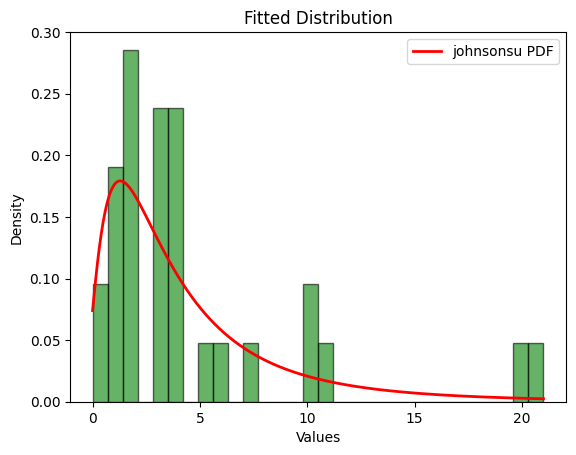

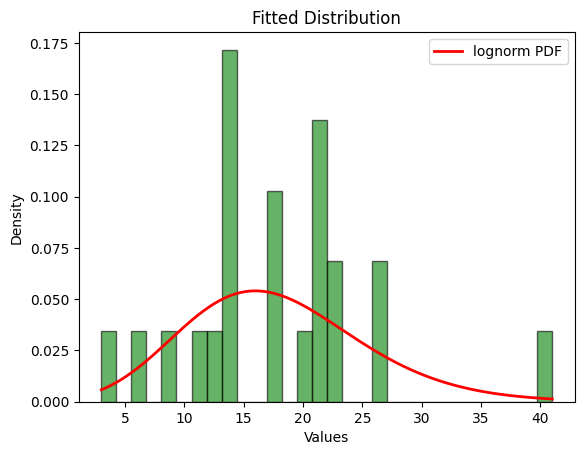

In [17]:
# book1 시각화
visualize_fitted_distribution(book1['ARRIVAL_DIFF'], 'johnsonsu', params=(-5.412009795166383, 1.2158269960642396, -0.6442993759442319, 0.08848608166937053))
visualize_fitted_distribution(book1['SERVICE_DIFF'], 'lognorm', params=(0.1656956836459968, -27.963582289149212, 45.16307141247669))

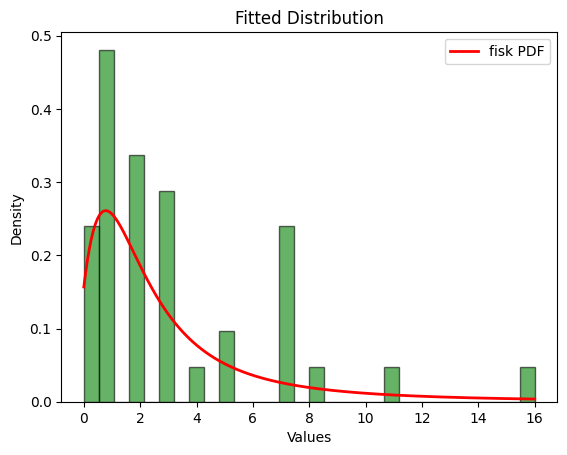

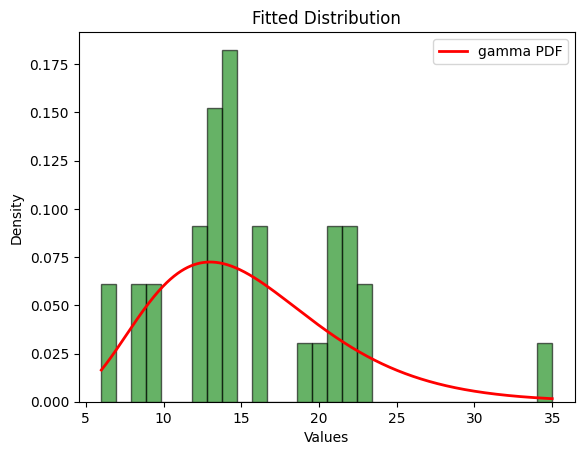

In [18]:
# book2 시각화
visualize_fitted_distribution(book2['ARRIVAL_DIFF'], 'fisk', params= (1.7006491394342107, -0.28853320615226913, 2.356547479289439))
visualize_fitted_distribution(book2['SERVICE_DIFF'], 'gamma', params=(5.555446437445503, 1.4562352649119112, 2.533221426425163))

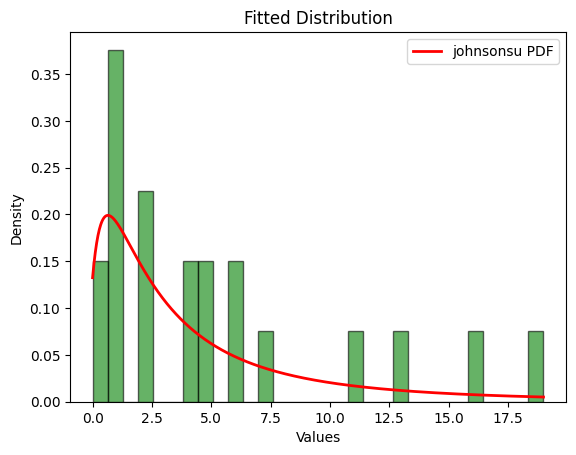

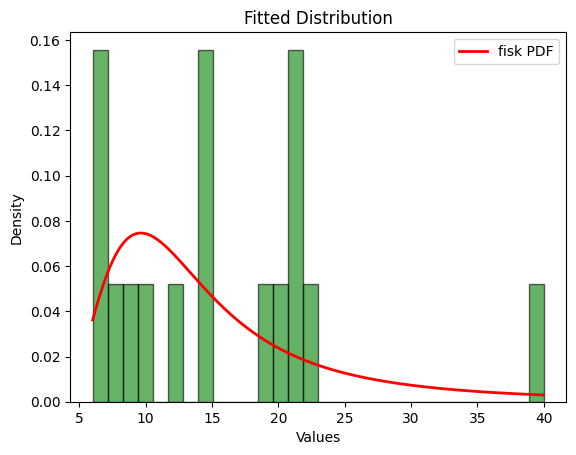

In [19]:
# book3 시각화
visualize_fitted_distribution(book3['ARRIVAL_DIFF'], 'johnsonsu', params=(-5.580412898464843, 0.9277379891052998, -0.39322457862293647, 0.01623231780865644))
visualize_fitted_distribution(book3['SERVICE_DIFF'], 'fisk', params=(2.0321905831010936, 4.467234342314011, 8.768907777431258))

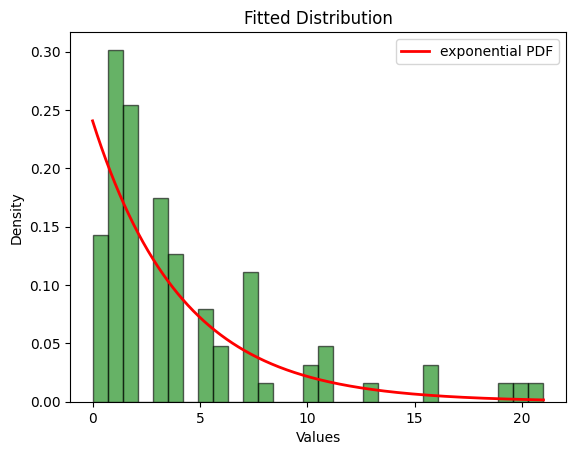

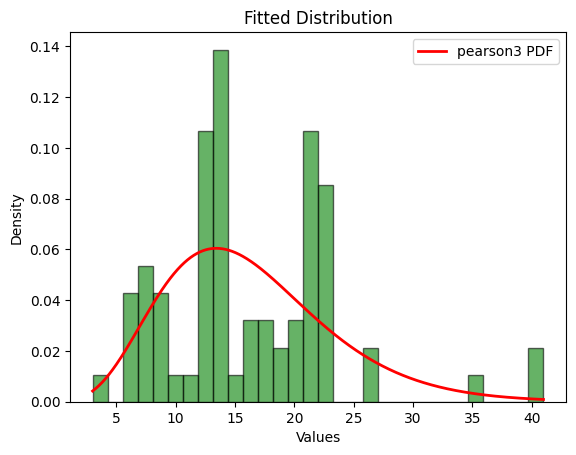

In [21]:
# book_df 시각화
visualize_fitted_distribution(book_df['ARRIVAL_DIFF'], 'exponential', params=(0.0, 4.155555555555556))
visualize_fitted_distribution(book_df['SERVICE_DIFF'], 'pearson3', params=(0.8018009758013036, 16.270234462863822, 7.090207917143562))

In [20]:
# missing rate 계산
print(book1['MISSING_RATE'].mean())
print(book2['MISSING_RATE'].mean())
print(book3['MISSING_RATE'].mean())

0.3055555555555555
0.1590909090909091
0.25


In [41]:

def generate_random_from_inverse_cdf(dist_name, params, size):

    distributions = {
        'gamma': gamma,
        'exponential': expon,
        'chi2': chi2,
        'weibull_min': weibull_min,
        'lognorm': lognorm,
        'johnsonsu': johnsonsu,
        'johnsonsb': johnsonsb,
        'fisk': fisk,
        'triang': triang,
        'pearson3': pearson3
    }

    if dist_name not in distributions:
        raise ValueError(f"Distribution {dist_name} is not supported.")

    dist = distributions[dist_name]
    u = uniform.rvs(size=size)
    random_vars = dist.ppf(u, *params)  # Inverse CDF
    return random_vars

def plot_generated_vs_observed(observed_data, generated_data, title='Generated vs Observed Data'):

    plt.figure(figsize=(10, 6))
    plt.hist(observed_data, bins=30, alpha=0.6, label='Observed Data', density=True, color='blue', edgecolor='black')
    plt.hist(generated_data, bins=30, alpha=0.6, label='Generated Data', density=True, color='orange', edgecolor='black')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def pp_plot_fixed(observed_data, simulated_data, title='Fixed P-P Plot'):

    # 데이터 범위 설정
    data_range = np.linspace(min(observed_data.min(), simulated_data.min()),
                             max(observed_data.max(), simulated_data.max()), 1000)

    # 관측 데이터와 생성 데이터의 CDF 계산
    observed_cdf = np.searchsorted(np.sort(observed_data), data_range, side='right') / len(observed_data)
    simulated_cdf = np.searchsorted(np.sort(simulated_data), data_range, side='right') / len(simulated_data)

    # P-P Plot
    plt.figure(figsize=(6, 6))
    plt.plot(observed_cdf, simulated_cdf, 'o', alpha=0.6, label='P-P Data', color='blue')
    plt.plot([0, 1], [0, 1], 'r--', label='Perfect Fit', linewidth=2)
    plt.title(title)
    plt.xlabel("Observed CDF")
    plt.ylabel("Simulated CDF")
    plt.legend()
    plt.grid(True)
    plt.show()

def qq_plot(observed_data, simulated_data, title='Q-Q Plot'):

    observed_sorted = np.sort(observed_data)
    simulated_sorted = np.sort(simulated_data)

    plt.figure(figsize=(6, 6))
    plt.scatter(observed_sorted, simulated_sorted, alpha=0.6, label='Data')
    plt.plot([min(observed_sorted), max(observed_sorted)],
             [min(observed_sorted), max(observed_sorted)], 'r--', label='Perfect Fit')
    plt.title(title)
    plt.xlabel('Observed Quantiles')
    plt.ylabel('Simulated Quantiles')
    plt.legend()
    plt.grid(True)
    plt.show()

def empirical_distribution(observed_data, generated_data, title='Empirical Distribution'):

    observed_sorted = np.sort(observed_data)
    observed_cdf = np.arange(1, len(observed_sorted) + 1) / len(observed_sorted)
    simulated_sorted = np.sort(generated_data)
    simulated_cdf = np.arange(1, len(simulated_sorted) + 1) / len(simulated_sorted)

    plt.figure(figsize=(10, 6))
    plt.step(observed_sorted, observed_cdf, label='Observed CDF', color='blue', where='post')
    plt.step(simulated_sorted, simulated_cdf, label='Generated CDF', color='orange', where='post')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

def empirical_vs_pp_plot(observed_data, simulated_data, title='Empirical vs P-P Plot'):

    # 데이터 범위 설정
    data_range = np.linspace(min(observed_data.min(), simulated_data.min()),
                             max(observed_data.max(), simulated_data.max()), 1000)

    # 관측 데이터와 생성 데이터의 CDF 계산
    observed_cdf = np.searchsorted(np.sort(observed_data), data_range, side='right') / len(observed_data)
    simulated_cdf = np.searchsorted(np.sort(simulated_data), data_range, side='right') / len(simulated_data)

    # Empirical Distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.step(data_range, observed_cdf, label='Observed CDF', color='blue', where='post')
    plt.step(data_range, simulated_cdf, label='Generated CDF', color='orange', where='post')
    plt.title('Empirical Distribution')
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True)

    # P-P Plot
    plt.subplot(1, 2, 2)
    plt.plot(observed_cdf, simulated_cdf, 'o', alpha=0.6, label='P-P Data', color='blue')
    plt.plot([0, 1], [0, 1], 'r--', label='Perfect Fit', linewidth=2)
    plt.title('P-P Plot')
    plt.xlabel("Observed CDF")
    plt.ylabel("Simulated CDF")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

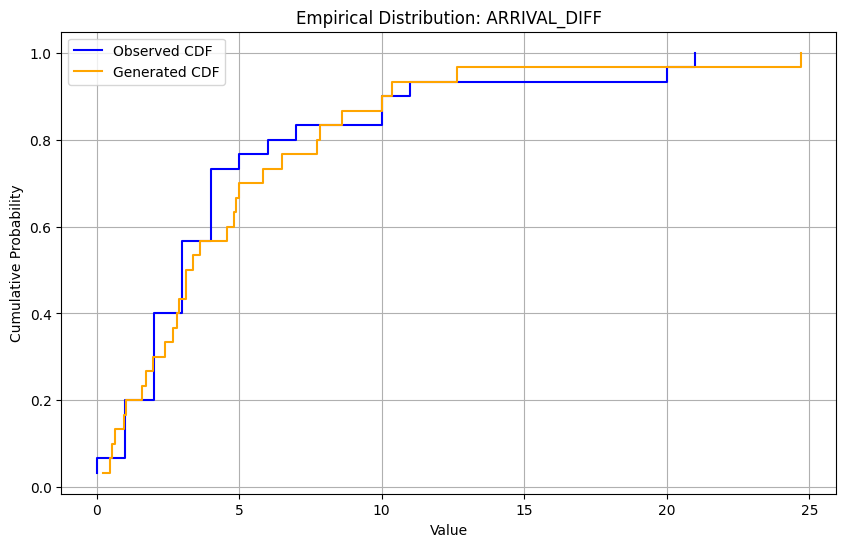

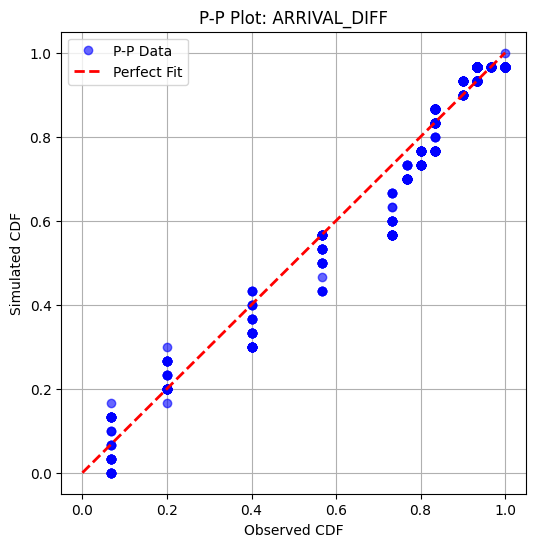

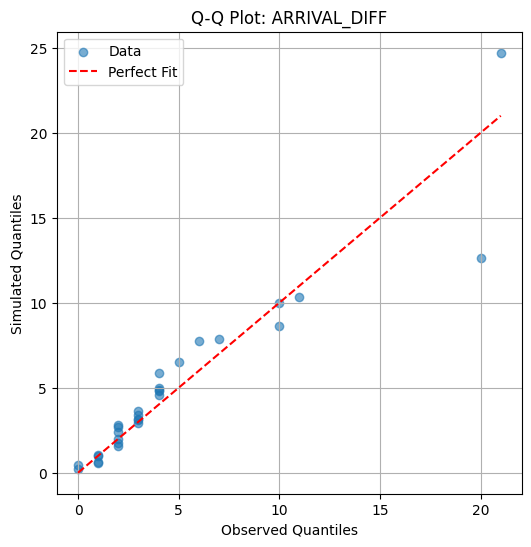

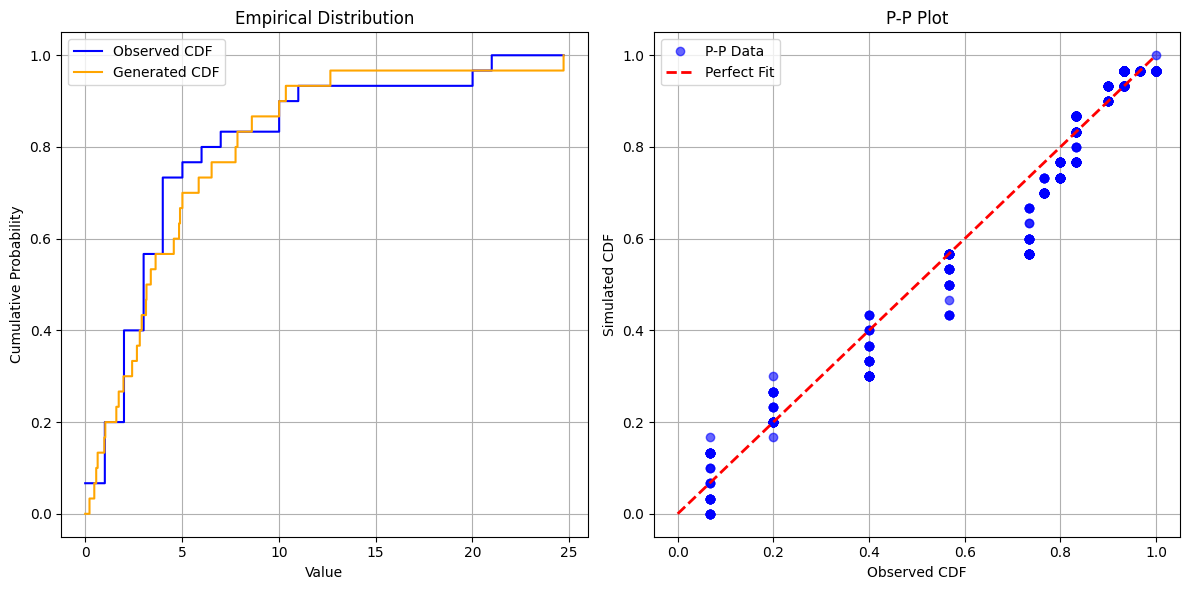

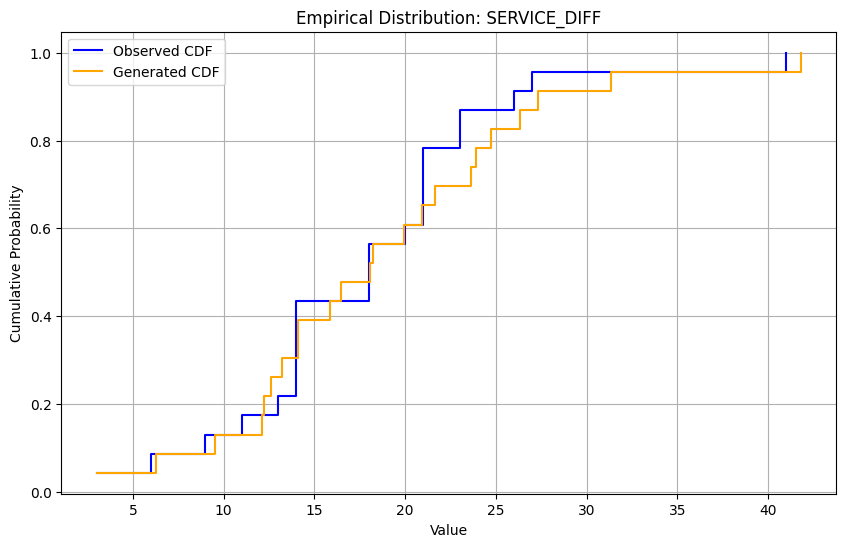

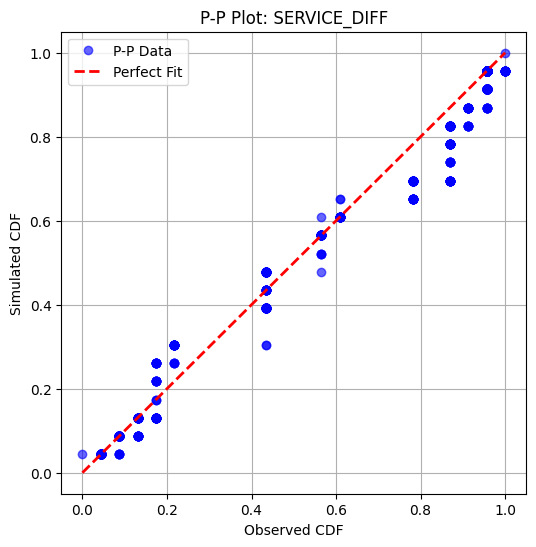

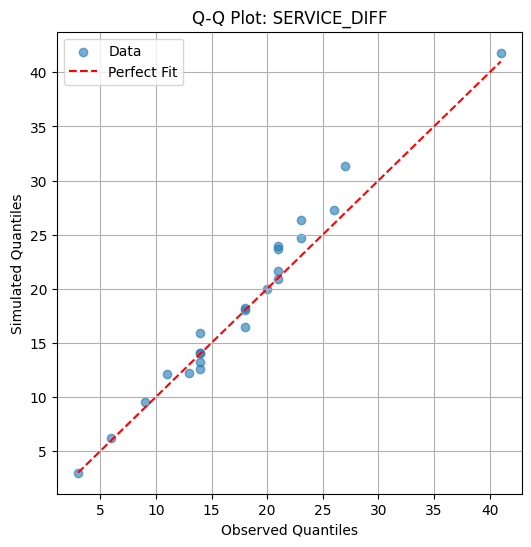

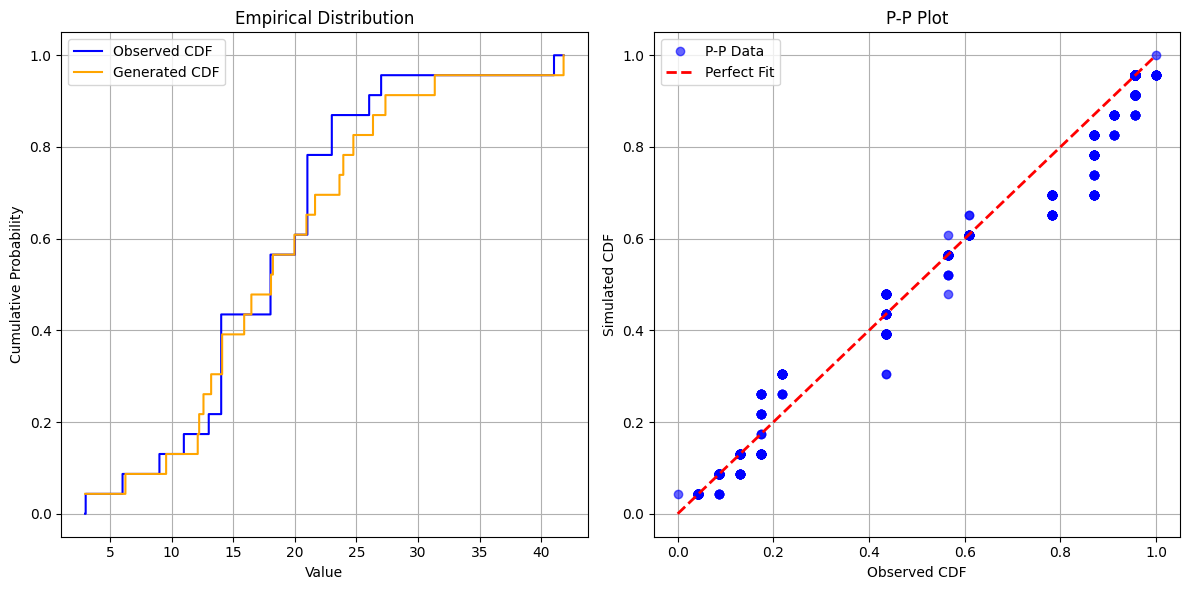

In [43]:
# Book 1 Data
dist_name = 'johnsonsu'
params = (-5.41, 1.22, -0.64, 0.09)
observed_data = book1['ARRIVAL_DIFF'].dropna()
simulated_data = generate_random_from_inverse_cdf(dist_name, params, size=len(observed_data))

empirical_distribution(observed_data, simulated_data, title='Empirical Distribution: ARRIVAL_DIFF')
pp_plot_fixed(observed_data, simulated_data, title='P-P Plot: ARRIVAL_DIFF')
qq_plot(observed_data, simulated_data, title='Q-Q Plot: ARRIVAL_DIFF')
empirical_vs_pp_plot(observed_data, simulated_data, title='Empirical vs P-P Plot: ARRIVAL_DIFF')

dist_name = 'lognorm'
params = (0.17, -27.96, 45.16)
observed_data = book1['SERVICE_DIFF'].dropna()
simulated_data = generate_random_from_inverse_cdf(dist_name, params, size=len(observed_data))

empirical_distribution(observed_data, simulated_data, title='Empirical Distribution: SERVICE_DIFF')
pp_plot_fixed(observed_data, simulated_data, title='P-P Plot: SERVICE_DIFF')
qq_plot(observed_data, simulated_data, title='Q-Q Plot: SERVICE_DIFF')
empirical_vs_pp_plot(observed_data, simulated_data, title='Empirical vs P-P Plot: SERVICE_DIFF')


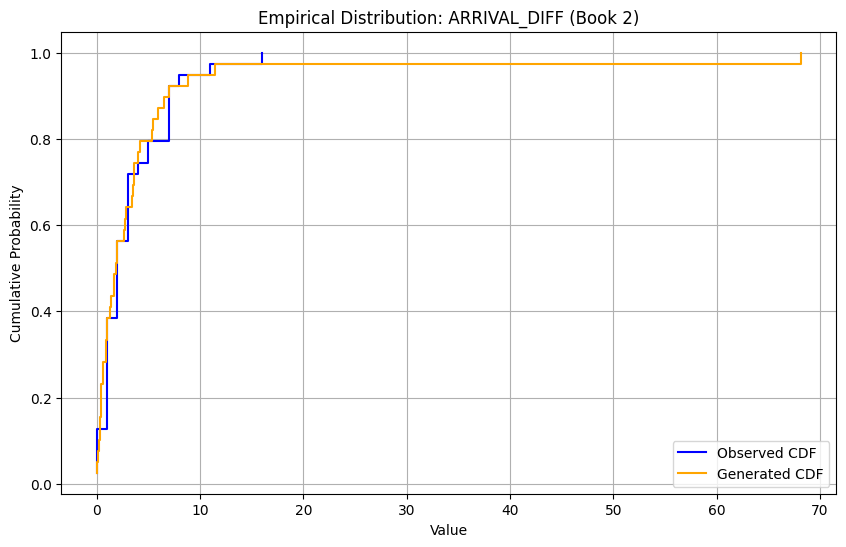

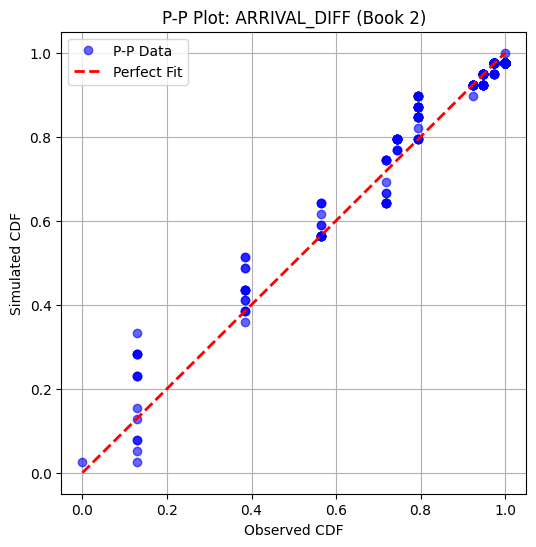

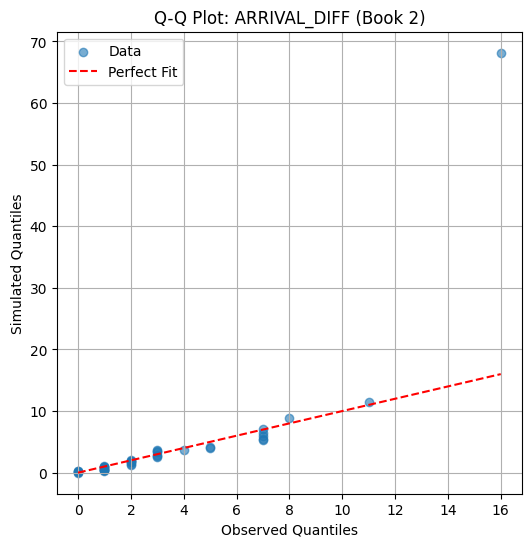

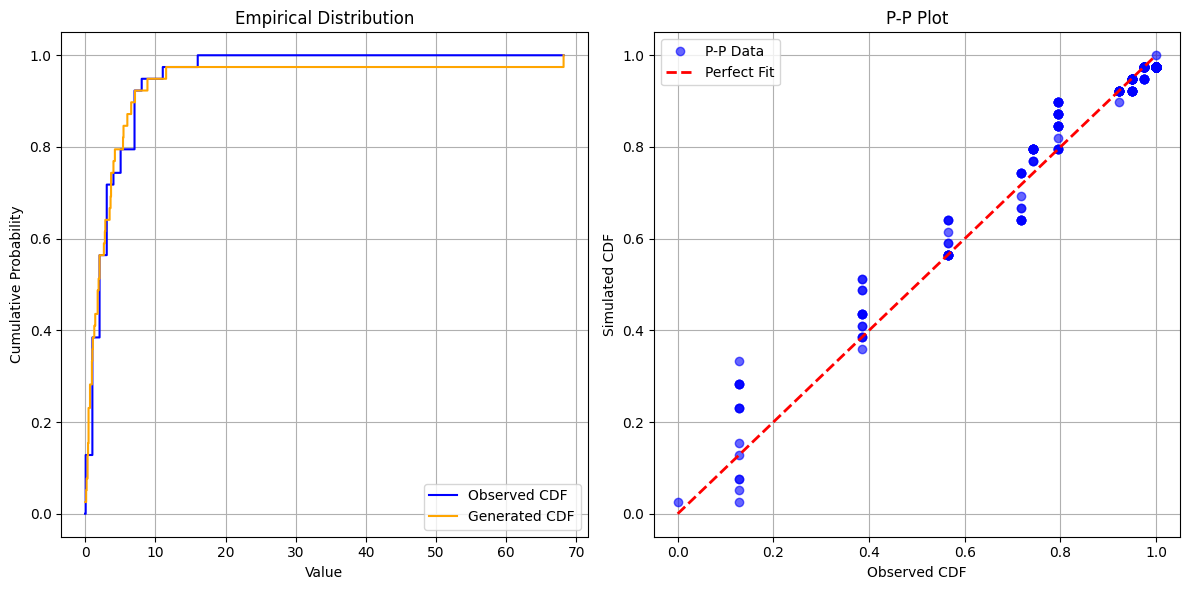

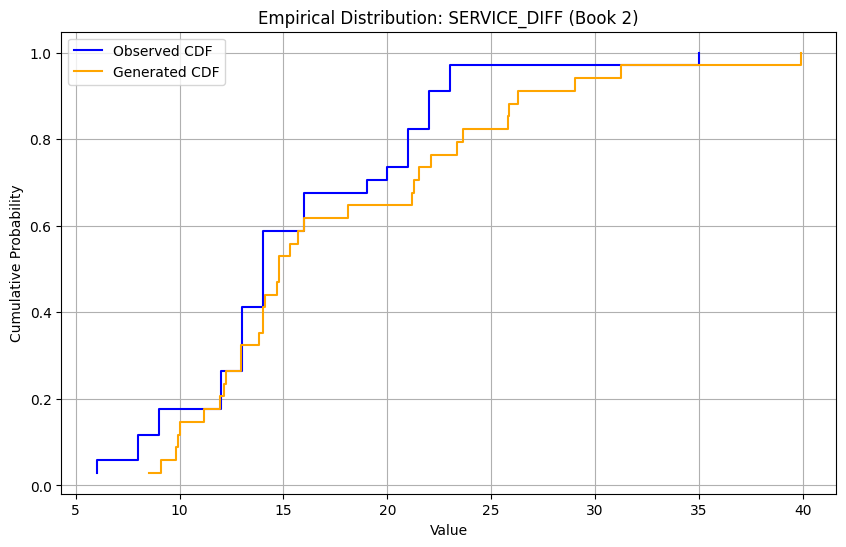

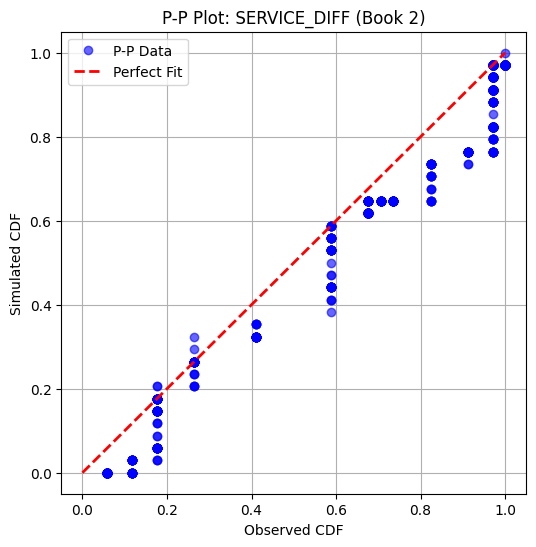

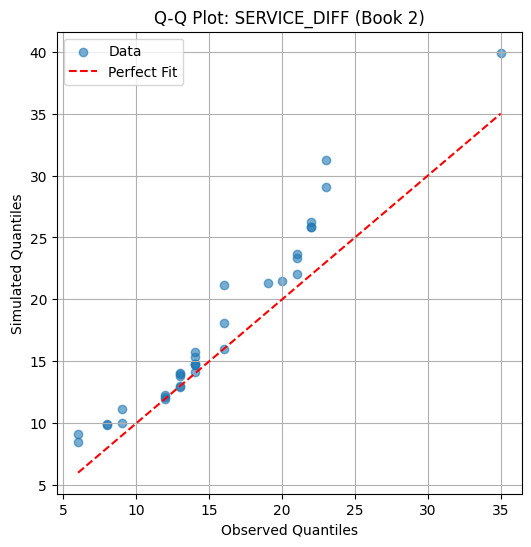

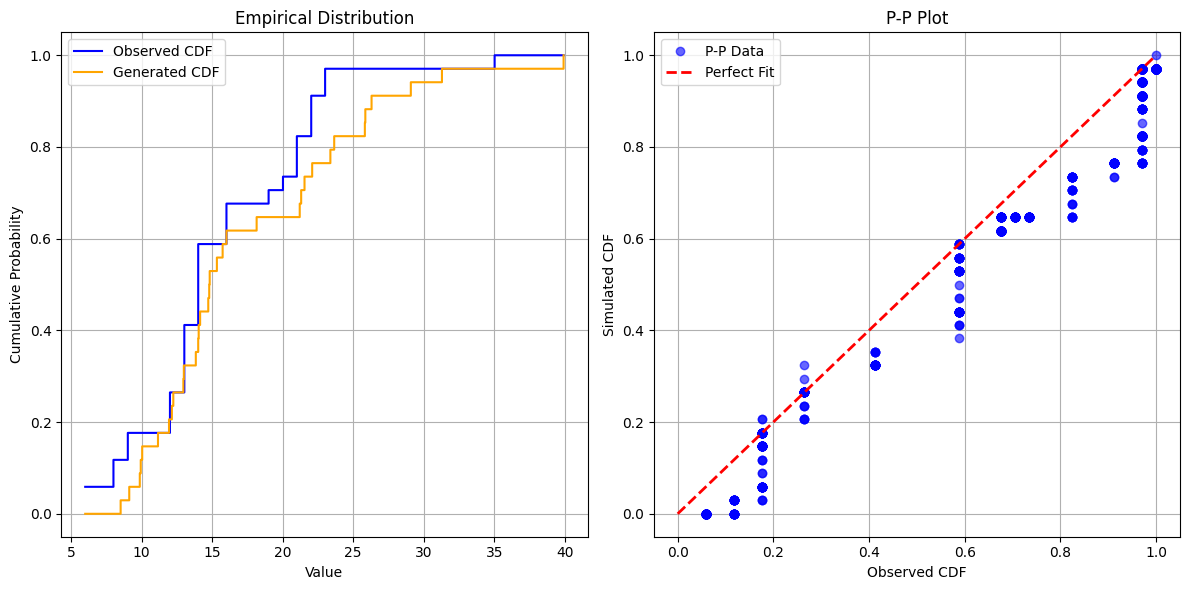

In [44]:
# Book 2
dist_name = 'fisk'
params = (1.70, -0.29, 2.36)
observed_data = book2['ARRIVAL_DIFF'].dropna()
simulated_data = generate_random_from_inverse_cdf(dist_name, params, size=len(observed_data))

empirical_distribution(observed_data, simulated_data, title='Empirical Distribution: ARRIVAL_DIFF (Book 2)')
pp_plot_fixed(observed_data, simulated_data, title='P-P Plot: ARRIVAL_DIFF (Book 2)')
qq_plot(observed_data, simulated_data, title='Q-Q Plot: ARRIVAL_DIFF (Book 2)')
empirical_vs_pp_plot(observed_data, simulated_data, title='Empirical vs P-P Plot: ARRIVAL_DIFF (Book 2)')

dist_name = 'gamma'
params = (5.56, 1.46, 2.53)
observed_data = book2['SERVICE_DIFF'].dropna()
simulated_data = generate_random_from_inverse_cdf(dist_name, params, size=len(observed_data))

empirical_distribution(observed_data, simulated_data, title='Empirical Distribution: SERVICE_DIFF (Book 2)')
pp_plot_fixed(observed_data, simulated_data, title='P-P Plot: SERVICE_DIFF (Book 2)')
qq_plot(observed_data, simulated_data, title='Q-Q Plot: SERVICE_DIFF (Book 2)')
empirical_vs_pp_plot(observed_data, simulated_data, title='Empirical vs P-P Plot: SERVICE_DIFF (Book 2)')



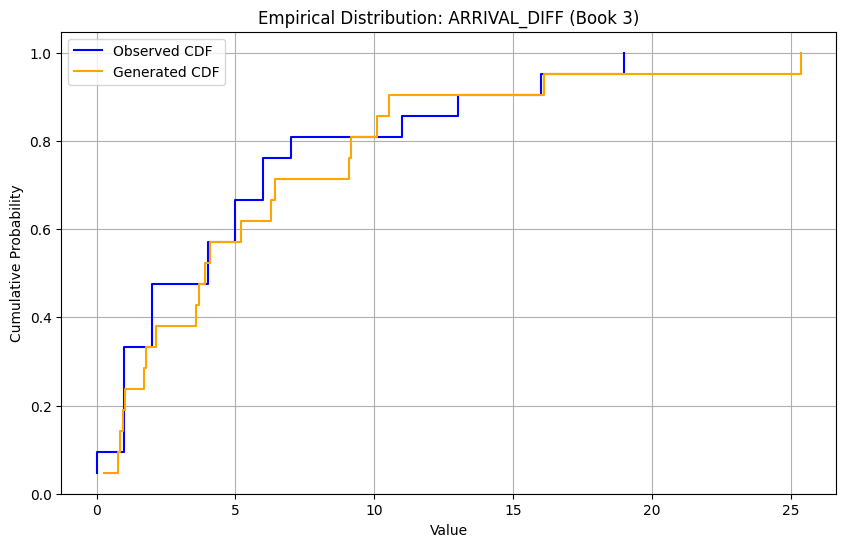

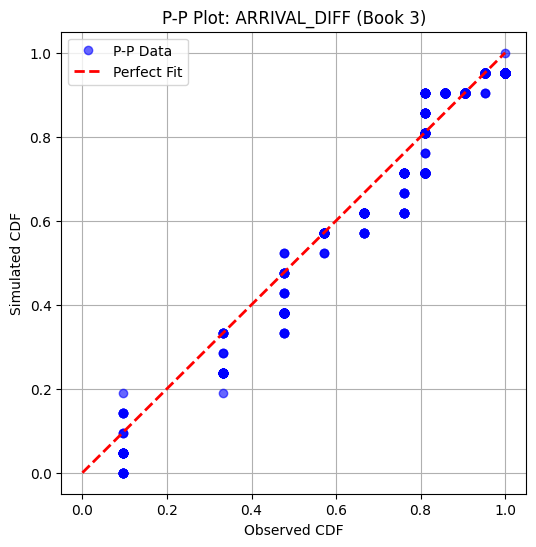

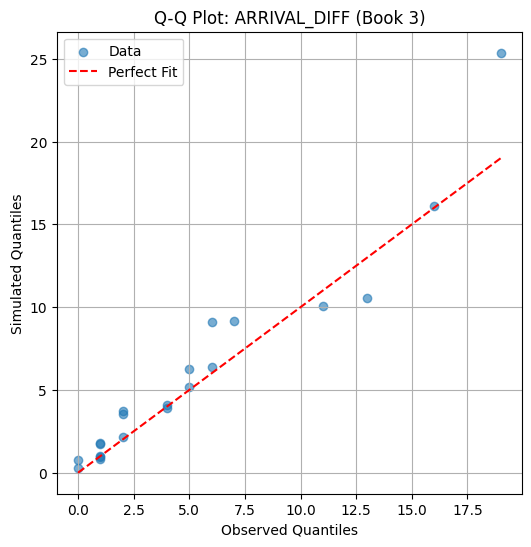

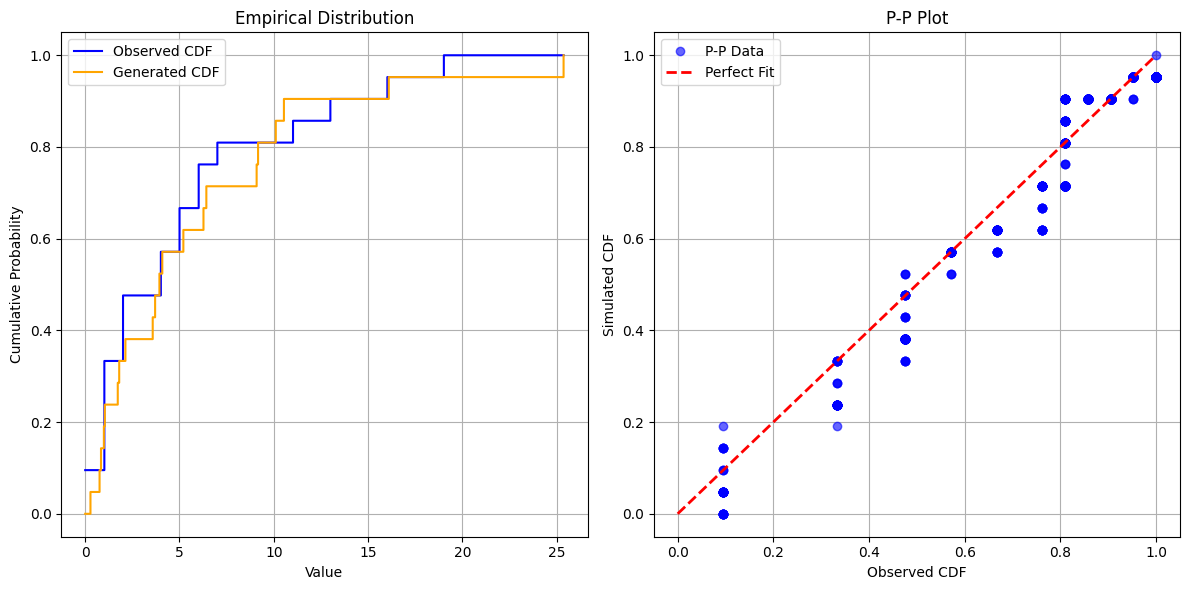

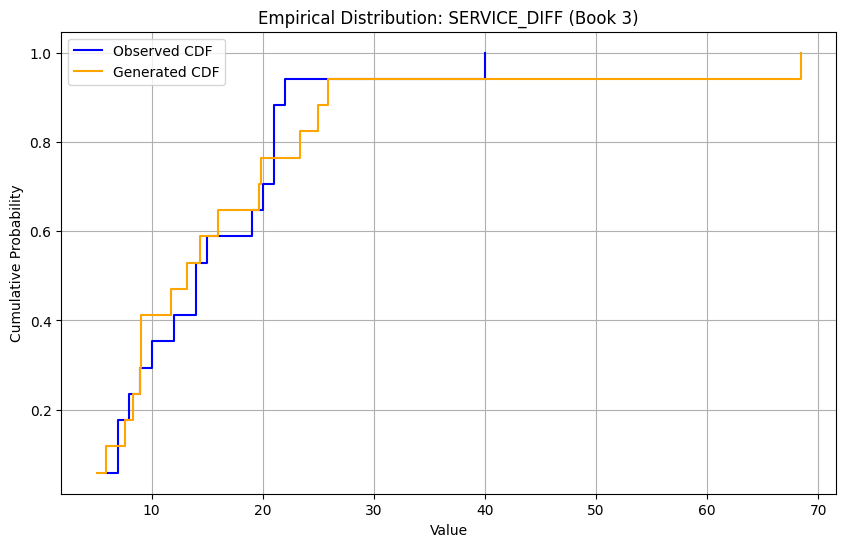

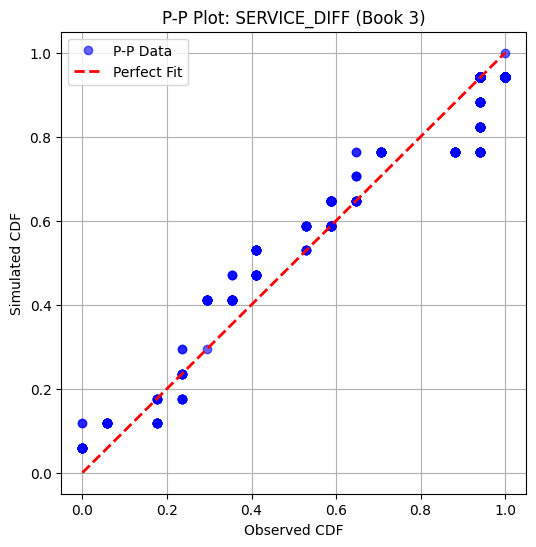

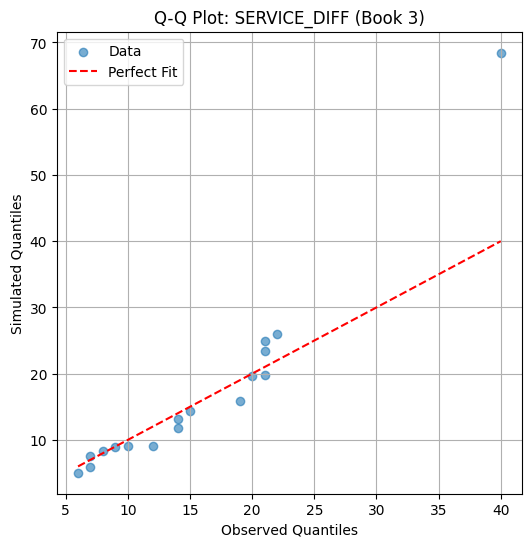

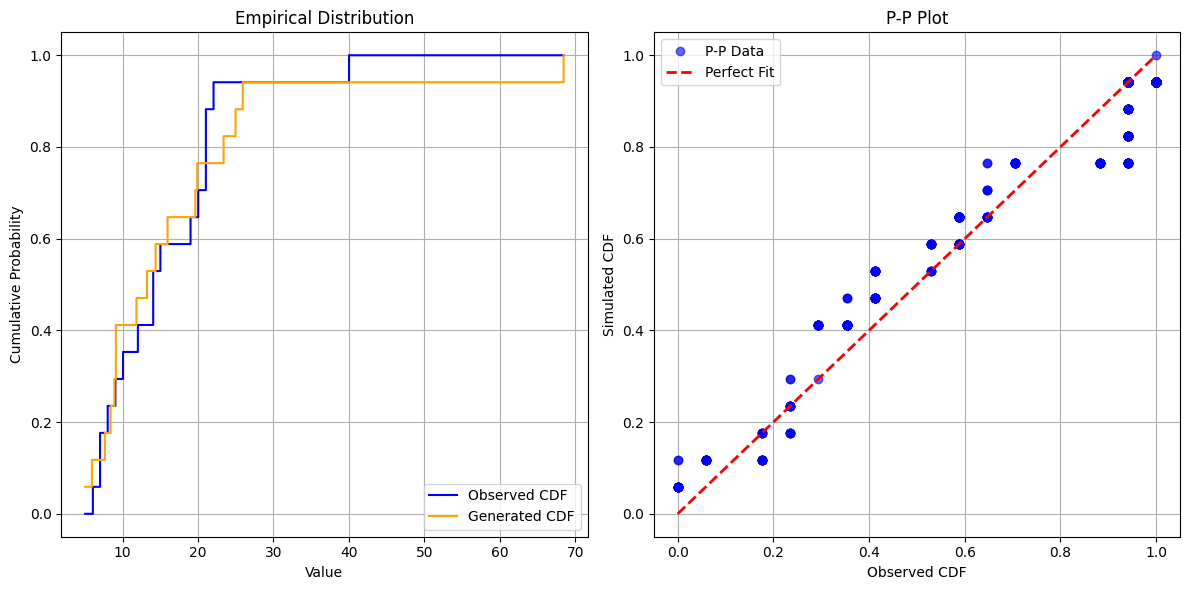

In [45]:
# Book 3
dist_name = 'johnsonsu'
params = (-5.58, 0.93, -0.39, 0.02)
observed_data = book3['ARRIVAL_DIFF'].dropna()
simulated_data = generate_random_from_inverse_cdf(dist_name, params, size=len(observed_data))

empirical_distribution(observed_data, simulated_data, title='Empirical Distribution: ARRIVAL_DIFF (Book 3)')
pp_plot_fixed(observed_data, simulated_data, title='P-P Plot: ARRIVAL_DIFF (Book 3)')
qq_plot(observed_data, simulated_data, title='Q-Q Plot: ARRIVAL_DIFF (Book 3)')
empirical_vs_pp_plot(observed_data, simulated_data, title='Empirical vs P-P Plot: ARRIVAL_DIFF (Book 3)')

dist_name = 'fisk'
params = (2.03, 4.47, 8.77)
observed_data = book3['SERVICE_DIFF'].dropna()
simulated_data = generate_random_from_inverse_cdf(dist_name, params, size=len(observed_data))

empirical_distribution(observed_data, simulated_data, title='Empirical Distribution: SERVICE_DIFF (Book 3)')
pp_plot_fixed(observed_data, simulated_data, title='P-P Plot: SERVICE_DIFF (Book 3)')
qq_plot(observed_data, simulated_data, title='Q-Q Plot: SERVICE_DIFF (Book 3)')
empirical_vs_pp_plot(observed_data, simulated_data, title='Empirical vs P-P Plot: SERVICE_DIFF (Book 3)')